In [1]:
from datasets import load_dataset

# Load the 'google/fleurs' dataset for 'hi_in' (Hindi - India)
dset = load_dataset("SEACrowd/indo_general_mt_en_id", trust_remote_code=True)


/home/fachri/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Split the dataset into training, validation, and test sets
train_data = dset['train']
val_data = dset['validation']
test_data = dset['test']

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, SimpleRNN, Embedding, Dense, Attention
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
import random
# Randomly select 10k indices
random_indices = random.sample(range(len(train_data)), 10000)

# Select the 10k rows
train_data = train_data.select(random_indices)
# Extract source (Indonesian) and target (English) texts from each split
train_source_texts = [example['src'] for example in train_data]
train_target_texts = [example['tgt'] for example in train_data]

val_source_texts = [example['src'] for example in val_data]
val_target_texts = [example['tgt'] for example in val_data]

test_source_texts = [example['src'] for example in test_data]
test_target_texts = [example['tgt'] for example in test_data]

2024-12-02 08:14:47.102168: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 08:14:47.124978: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 08:14:47.125000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 08:14:47.126012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 08:14:47.130582: I tensorflow/core/platform/cpu_feature_guar

In [5]:
import numpy as np

# Assuming `train_source_texts` and `train_target_texts` are NumPy arrays or lists
combined_data = np.column_stack((val_source_texts, val_target_texts))

# Save to a text file
with open("combined_data_val.csv", "w", encoding="utf-8") as f:
    for row in combined_data:
        f.write(f"{row[0]},{row[1]}\n")

In [19]:
# Add special tokens to your training data
train_target_texts = ["<SOS> " + text + " <EOS>" for text in train_target_texts]
val_target_texts = ["<SOS> " + text + " <EOS>" for text in val_target_texts]
test_target_texts = ["<SOS> " + text + " <EOS>" for text in test_target_texts]


In [20]:
train_target_texts

['<SOS> "Tatsuki memanggilnya ""Bro""." <EOS>',
 '<SOS> Billy keluar dari akademi dan meluangkan waktu di penjara dengan tuduhan penyerangan palsu untuk meningkatkan kepercayaannya. <EOS>',
 '<SOS> Achmad Basarah berpendapat bahwa Bambang D.H. memiliki karakter dan ideologi nasional yang kuat. <EOS>',
 '<SOS> Hal itu membuat Mahmudin menjadi kesal dan tertekan. <EOS>',
 '<SOS> "Pepatah yang sering dikutip tersebut tidak merepresentasikan ajaran Katolik resmi mengenai indulgensi, melainkan lebih merupakan suatu cerminan dari kapasitas Tetzel yang melebih-lebihkannya." <EOS>',
 '<SOS> "Vladimir Kirillovich, yang wafat pada 1992, meninggalkan seluruh anggota dinasti Romanov laki-laki lainnya, dan putrinya tidak berkesempatan menyandang gelar korator." <EOS>',
 '<SOS> """Judika Didaulat Jadi Juri The Voice Indonesia 2016""." <EOS>',
 '<SOS> "Dari semua, hanya satu, Martin Van Buren, yang mempelajari bahasa Inggris sebagai bahasa kedua, bahasa pertamanya adalah bahasa Belanda." <EOS>',
 '<S

In [21]:
# Tokenization (Source and Target)
source_tokenizer = Tokenizer()
target_tokenizer = Tokenizer()

source_tokenizer.fit_on_texts(train_source_texts)
target_tokenizer.fit_on_texts(train_target_texts)

source_vocab_size = len(source_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

# Convert texts to sequences
train_source_sequences = source_tokenizer.texts_to_sequences(train_source_texts)
train_target_sequences = target_tokenizer.texts_to_sequences(train_target_texts)

val_source_sequences = source_tokenizer.texts_to_sequences(val_source_texts)
val_target_sequences = target_tokenizer.texts_to_sequences(val_target_texts)

test_source_sequences = source_tokenizer.texts_to_sequences(test_source_texts)
test_target_sequences = target_tokenizer.texts_to_sequences(test_target_texts)

In [22]:
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

# Define maximum sequence lengths (modify as needed)
# max_source_length = max(len(seq) for seq in train_source_sequences)
# max_target_length = max(len(seq) for seq in train_target_sequences)
max_source_length = 60
max_target_length = 60

# Pad sequences to ensure uniform length
train_source_sequences = pad_sequences(train_source_sequences, maxlen=max_source_length, padding='post')
train_target_sequences = pad_sequences(train_target_sequences, maxlen=max_target_length, padding='post')

val_source_sequences = pad_sequences(val_source_sequences, maxlen=max_source_length, padding='post')
val_target_sequences = pad_sequences(val_target_sequences, maxlen=max_target_length, padding='post')

test_source_sequences = pad_sequences(test_source_sequences, maxlen=max_source_length, padding='post')
test_target_sequences = pad_sequences(test_target_sequences, maxlen=max_target_length, padding='post')

# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_source_sequences, train_target_sequences))
val_dataset = tf.data.Dataset.from_tensor_slices((val_source_sequences, val_target_sequences))
test_dataset = tf.data.Dataset.from_tensor_slices((test_source_sequences, test_target_sequences))

# Batch and shuffle the training dataset
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size, drop_remainder=True)
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

# Print dataset samples to verify
for source, target in train_dataset.take(1):
    print('Source batch shape:', source.shape)
    print('Target batch shape:', target.shape)


Source batch shape: (32, 60)
Target batch shape: (32, 60)


In [23]:
#
# Encoder
#
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn = tf.keras.layers.SimpleRNN(
            self.enc_units,
            return_sequences=False,  # Set to True if you need the full sequence
            return_state=True,       # Set to True if you want the last state
            recurrent_initializer="glorot_uniform",
        )

    def call(self, x):
        x = self.embedding(x)
        output, state = self.rnn(x)  # Get both output and last state
        return state  # Return the last hidden state


In [24]:
#
# Decoder
#
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn = tf.keras.layers.SimpleRNN(
            self.dec_units,
            return_sequences=True,  # Set to True to return the full sequence
            return_state=True,      # Set to True to return the last state
            recurrent_initializer="glorot_uniform",
        )
        self.softmax = tf.keras.layers.Dense(vocab_size, activation="softmax")

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.rnn(inputs=x, initial_state=hidden)  # Use SimpleRNN here
        output = self.softmax(output)
        return output, state

In [25]:
# ========================================
# Create model
# ========================================

embedding_dim = 256
units = 1024  # LSTM/GRU dimensionality of the output space.

encoder = Encoder(source_vocab_size, embedding_dim, units, batch_size)
decoder = Decoder(target_vocab_size, embedding_dim, units, batch_size)

optimizer = tf.compat.v1.train.AdamOptimizer()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="val_accuracy")

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # this masks '<pad>'
    """
    Example:

    real= tf.Tensor(
    [[21  1 44 0  0]   (jump !    <eos> <pad> <pad>)
    [ 17  9 24 2 44]   (i    go   there .     <eos>)
    [ 27  1 44 0  0]   (no   !    <eos> <pad> <pad>)
    [ 21 22 32 2 44]], (i    know you   .     <eos>)
    , shape=(4, 5), dtype=int64)

    where <pad> = 0.

    mask= tf.Tensor(
    [[True  True  True False False]
    [ True  True  True True  True ]
    [[True  True  True False False]
    [ True  True  True True  True ],
    shape=(4, 5), dtype=bool)
    """

    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [26]:
import tensorflow as tf
tf.__version__
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [27]:
CHECKPOINT = False

In [28]:
# ========================================
# Training
# ========================================
import os
import csv
checkpoint_path = (
    "./checkpointsRNNnew/seq2seq-sample-"
    + str(500)
    + "-embedding-"
    + str(embedding_dim)
    + "-hidden-"
    + str(units)
)

if CHECKPOINT == True:
    ckpt = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=2)
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print("Latest checkpoint restored!!")

def append_loss_to_csv(epoch, train_loss, val_loss, time_taken, csv_path="training_rnn_results.csv"):
    file_exists = os.path.exists(csv_path)
    with open(csv_path, mode="a", newline="") as file:
        writer = csv.writer(file)
        if not file_exists:
            # Write header if the file is being created for the first time
            writer.writerow(["Epoch", "Train Loss", "Val Loss", "Time Taken"])
        # Append the new epoch's losses
        writer.writerow([epoch, train_loss.numpy(), val_loss.numpy(), time_taken])
    print(f"Epoch {epoch + 1}:Val Loss: {val_loss:.4f} - Saved to {csv_path}.")

@tf.function
def train(encoder, decoder, source_sentences, target_sentences, target_lang_tokenizer):
    with tf.GradientTape() as tape:
        context_vector = encoder(source_sentences)

        dec_input = target_sentences[:, :-1]  # Decoder input
        expected_dec_output = target_sentences[:, 1:]  # Expected output

        predictions, _ = decoder(dec_input, context_vector)
        loss = loss_function(expected_dec_output, predictions)
        train_accuracy(expected_dec_output, predictions)

    batch_loss = loss / int(target_sentences.shape[1])
    variables = encoder.variables + decoder.variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss


@tf.function
def validate(encoder, decoder, source_sentences, target_sentences, target_lang_tokenizer):
    context_vector = encoder(source_sentences)
    dec_input = target_sentences[:, :-1]  # Decoder input
    expected_dec_output = target_sentences[:, 1:]  # Expected output

    predictions, _ = decoder(dec_input, context_vector)
    loss = loss_function(expected_dec_output, predictions)
    val_accuracy(expected_dec_output, predictions)  # Assuming you have val_accuracy defined

    return loss


# Set n_epochs at least 20 when you do training.
n_epochs = 40

# Prepare to store loss and accuracy
loss_history = []
accuracy_history = []
val_loss_history = []
val_accuracy_history = []

import time
for epoch in range(1, n_epochs + 1):
    start = time.time()

    total_loss = 0
    total_val_loss = 0
    train_accuracy.reset_states()
    val_accuracy.reset_states()  # Reset validation accuracy

    # Training loop
    for (batch, (source_sentences, target_sentences)) in enumerate(train_dataset):
        batch_loss = train(encoder, decoder, source_sentences, target_sentences, target_tokenizer)
        total_loss += batch_loss

        if batch % 100 == 0:
            print("Epoch {} Batch {} Loss {:.4f} Accuracy: {:.4f}".format(epoch, batch, batch_loss.numpy(), train_accuracy.result()))

    # Store the average loss and accuracy for this epoch
    avg_loss = total_loss / (batch + 1)
    loss_history.append(avg_loss)
    accuracy_history.append(train_accuracy.result().numpy())

    # Validation loop
    for (val_source_sentences, val_target_sentences) in val_dataset:
        val_loss = validate(encoder, decoder, val_source_sentences, val_target_sentences, target_tokenizer)
        total_val_loss += val_loss

    # Store the average validation loss and accuracy for this epoch
    avg_val_loss = total_val_loss / len(val_dataset)
    val_loss_history.append(avg_val_loss)
    val_accuracy_history.append(val_accuracy.result().numpy())

    if CHECKPOINT == True:
        ckpt_save_path = ckpt_manager.save()
        print("Saving checkpoint for epoch {} at {}".format(epoch, ckpt_save_path))
    time_taken = time.time() - start
    append_loss_to_csv(epoch, avg_loss, avg_val_loss, time_taken)
    print("Epoch {}/{} Loss {:.4f} Val Loss {:.4f}".format(epoch, n_epochs, avg_loss, avg_val_loss))
    print("Time taken for 1 epoch {:.4f} sec\n".format(time_taken))



Epoch 1 Batch 0 Loss 0.0563 Accuracy: 0.0000
Epoch 1 Batch 100 Loss 0.0526 Accuracy: 0.0110
Epoch 1 Batch 200 Loss 0.0475 Accuracy: 0.0150
Epoch 1 Batch 300 Loss 0.0466 Accuracy: 0.0165
Epoch 2:Val Loss: 2.2526 - Saved to training_rnn_results.csv.
Epoch 1/40 Loss 0.0475 Val Loss 2.2526
Time taken for 1 epoch 35.6915 sec

Epoch 2 Batch 0 Loss 0.0439 Accuracy: 0.0191
Epoch 2 Batch 100 Loss 0.0373 Accuracy: 0.0206
Epoch 2 Batch 200 Loss 0.0486 Accuracy: 0.0204
Epoch 2 Batch 300 Loss 0.0422 Accuracy: 0.0209
Epoch 3:Val Loss: 2.1741 - Saved to training_rnn_results.csv.
Epoch 2/40 Loss 0.0435 Val Loss 2.1741
Time taken for 1 epoch 34.9692 sec

Epoch 3 Batch 0 Loss 0.0451 Accuracy: 0.0207
Epoch 3 Batch 100 Loss 0.0459 Accuracy: 0.0238
Epoch 3 Batch 200 Loss 0.0412 Accuracy: 0.0236
Epoch 3 Batch 300 Loss 0.0423 Accuracy: 0.0240
Epoch 4:Val Loss: 2.1241 - Saved to training_rnn_results.csv.
Epoch 3/40 Loss 0.0408 Val Loss 2.1241
Time taken for 1 epoch 35.2840 sec

Epoch 4 Batch 0 Loss 0.0378 Acc

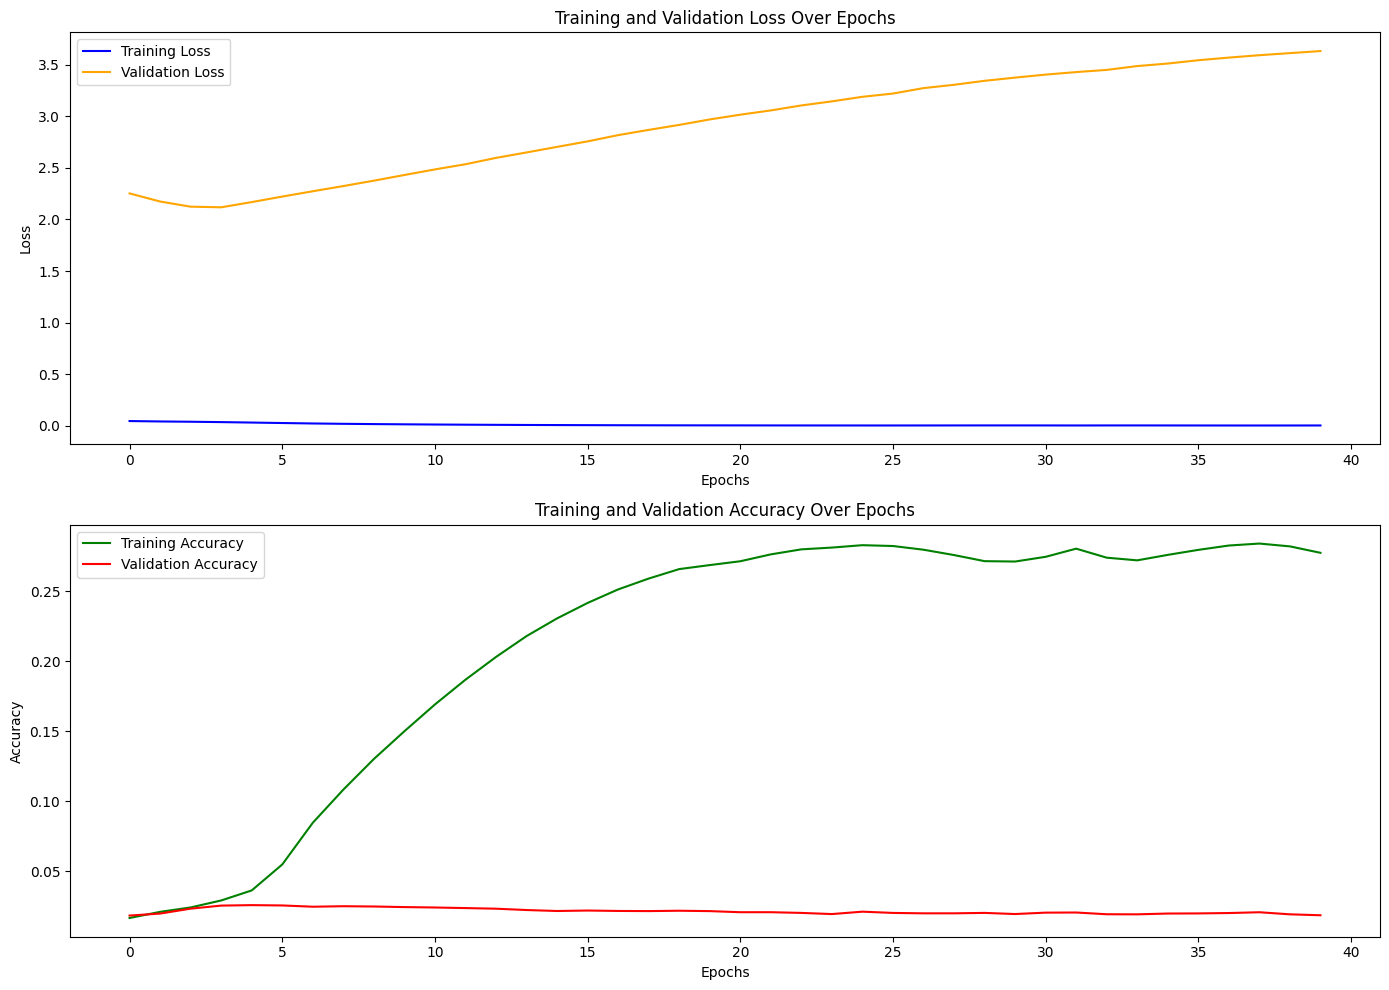

In [29]:
import matplotlib.pyplot as plt
# Plotting Loss and Accuracy
plt.figure(figsize=(14, 10))

# Loss plot
plt.subplot(2, 1, 1)
plt.plot(loss_history, label='Training Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(2, 1, 2)
plt.plot(accuracy_history, label='Training Accuracy', color='green')
plt.plot(val_accuracy_history, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [30]:
target_tokenizer.word_index

{'sos': 1,
 'eos': 2,
 'dan': 3,
 'yang': 4,
 'di': 5,
 'pada': 6,
 'dari': 7,
 'dengan': 8,
 'untuk': 9,
 'ini': 10,
 'dalam': 11,
 'tahun': 12,
 'adalah': 13,
 'oleh': 14,
 'sebagai': 15,
 'ia': 16,
 'ke': 17,
 'tidak': 18,
 'menjadi': 19,
 'tersebut': 20,
 'juga': 21,
 'mereka': 22,
 'sebuah': 23,
 'atau': 24,
 'bahwa': 25,
 'itu': 26,
 'orang': 27,
 'lebih': 28,
 'telah': 29,
 'setelah': 30,
 'film': 31,
 'satu': 32,
 'karena': 33,
 'dia': 34,
 'bahasa': 35,
 'tanggal': 36,
 'memiliki': 37,
 'akan': 38,
 'dapat': 39,
 'pertama': 40,
 'negara': 41,
 'beberapa': 42,
 'secara': 43,
 'saat': 44,
 'seorang': 45,
 'the': 46,
 'kota': 47,
 'merupakan': 48,
 'kemudian': 49,
 'seperti': 50,
 'besar': 51,
 'nama': 52,
 'para': 53,
 '1': 54,
 'namun': 55,
 'amerika': 56,
 '2': 57,
 'ada': 58,
 'inggris': 59,
 'selama': 60,
 'banyak': 61,
 'dua': 62,
 'atas': 63,
 'antara': 64,
 'bagian': 65,
 'dunia': 66,
 'baru': 67,
 'sama': 68,
 'lain': 69,
 'kepada': 70,
 'hanya': 71,
 'ketika': 72,
 'tet

In [31]:
# ========================================
# Translation
# ========================================

def evaluate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer):

    inputs = source_lang_tokenizer.texts_to_sequences([sentence])[0]

    inputs = tf.compat.v1.keras.preprocessing.sequence.pad_sequences(
        [inputs], maxlen=max_source_length, padding="post"
    )
    inputs = tf.convert_to_tensor(inputs)

    result = ""

    context_vector = encoder(inputs)
    dec_hidden = context_vector
    dec_input = tf.expand_dims([target_lang_tokenizer.word_index["sos"]], 0)

    for t in range(max_target_length):
        #
        # Greedy Search
        #
        predictions, dec_hidden = decoder(dec_input, dec_hidden)
        predicted_id = tf.argmax(predictions[0][0]).numpy()
        result += target_lang_tokenizer.index_word[predicted_id] + " "
        if target_lang_tokenizer.index_word[predicted_id] == "eos":
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result


def translate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer):
    result = evaluate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer)
    return result.capitalize()

"""
# for debug:
#sentence = "Su voz suena muy bello."
#sentence = "No nos gusta la lluvia."
sentence = "Nos gusta la lluvia."
result = translate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer)
print("Input    : {}".format(sentence))
print("Predicted: {}".format(result))

sys.exit()
"""
#
#
# Helper function to detokenize a sequence to text
def detokenize(sequence, tokenizer):
    return ' '.join([tokenizer.index_word.get(idx, '') for idx in sequence if idx != 0])

keys = np.arange(len(val_source_sequences))
keys = np.random.permutation(keys)[:10]

for i in range(len(keys)):
    print("===== [{}] ======".format(i + 1))
    sentence = detokenize(val_source_sequences[i], source_tokenizer)
    result = translate(sentence, encoder, decoder, source_tokenizer, target_tokenizer)
    print("Input    : {}".format(sentence))
    print("Predicted: {}".format(result))
    print("Correct  : {}".format(detokenize(val_target_sequences[i],target_tokenizer)))

encoder.summary()
decoder.summary()
decoder.get_config()

===== [1] ======
Input    : in the western half the volume increased from 89 million m3 per year in 1998 to 130 in 2007 and 153 in 2011
Predicted: Di perguruan tinggi tersebut bechtel menjadi seorang pelari jarak jauh yang berbakat dan berharap untuk mencoba untuk olimpiade musim panas 2000 eos 
Correct  : sos di jakarta bagian barat volume naik dari 89 juta m3 per tahun pada 1998 menjadi 130 pada 2007 dan 153 pada 2011 eos
===== [2] ======
Input    : she obtained a scholarship from the state department to study politics in the us
Predicted: Di perguruan tinggi tersebut bechtel menjadi seorang pelari jarak jauh yang berbakat dan berharap untuk mencoba untuk olimpiade musim panas 2000 eos 
Correct  : sos kemudian ia mendapat beasiswa dari gereja metodis untuk belajar di amerika serikat eos
===== [3] ======
Input    : the bridge is the main connection between downtown belgrade and new belgrade and also carries the transit traffic on and through serbia
Predicted: Sejak awal ch'ŏnma ho tam

{'vocab_size': 30297, 'embedding_dim': 256, 'dec_units': 1024, 'batch_sz': 32}

In [32]:
# ========================================
# Translation
# ========================================
import numpy as np
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction, sentence_bleu
import nltk
import csv
def evaluate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer):

    inputs = source_lang_tokenizer.texts_to_sequences([sentence])[0]

    inputs = tf.compat.v1.keras.preprocessing.sequence.pad_sequences(
        [inputs], maxlen=max_source_length, padding="post"
    )
    inputs = tf.convert_to_tensor(inputs)

    result = ""

    context_vector = encoder(inputs)
    dec_hidden = context_vector
    dec_input = tf.expand_dims([target_lang_tokenizer.word_index["sos"]], 0)

    for t in range(max_target_length):
        #
        # Greedy Search
        #
        predictions, dec_hidden = decoder(dec_input, dec_hidden)
        predicted_id = tf.argmax(predictions[0][0]).numpy()
        result += target_lang_tokenizer.index_word[predicted_id] + " "
        if target_lang_tokenizer.index_word[predicted_id] == "eos":
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result


def translate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer):
    result = evaluate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer)
    return result.capitalize()

"""
# for debug:
#sentence = "Su voz suena muy bello."
#sentence = "No nos gusta la lluvia."
sentence = "Nos gusta la lluvia."
result = translate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer)
print("Input    : {}".format(sentence))
print("Predicted: {}".format(result))

sys.exit()
"""
#
#
# Helper function to detokenize a sequence to text
def detokenize(sequence, tokenizer):
    return ' '.join([tokenizer.index_word.get(idx, '') for idx in sequence if idx != 0])


# Set the NLTK data path


def calculate_bleu(reference, hypothesis):
    # Tokenize the sentences for BLEU score calculation

    # Use the sentence_bleu function to calculate the score
    bleu_score = sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method1)
    return bleu_score

# ... (rest of your existing code)

keys = np.arange(len(test_source_sequences))

bleu_scores = []

for i in range(len(keys)):
    print("===== [{}] ======".format(i + 1))
    sentence = detokenize(test_source_sequences[keys[i]], source_tokenizer)
    result = translate(sentence, encoder, decoder, source_tokenizer, target_tokenizer)
    print("Input    : {}".format(sentence))
    print("Predicted: {}".format(result))
    correct_sentence = detokenize(test_target_sequences[keys[i]], target_tokenizer)
    print("Correct  : {}".format(correct_sentence))
    
    # Calculate and store the BLEU score
    bleu_score = calculate_bleu(correct_sentence, result)
    bleu_scores.append(bleu_score)
    print("BLEU Score: {:.4f}".format(bleu_score))
    # Save the BLEU scores to a CSV file
    with open('predictions_rnn_test.csv', mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([i + 1, sentence, result, correct_sentence, bleu_score])

# Calculate the average BLEU score for the sample
average_bleu_score = np.mean(bleu_scores)
print("Average BLEU Score for the sample: {:.4f}".format(average_bleu_score))

# Optionally, summarize encoder and decoder
# encoder.summary()
# decoder.summary()
# decoder.get_config()

===== [1] ======
Input    : gandhi imposed emergency rule in india
Predicted: Di perguruan tinggi tersebut bechtel menjadi seorang pelari jarak jauh yang berbakat dan berharap untuk mencoba untuk olimpiade musim panas 2000 eos 
Correct  : sos kemudian mendirikan perusahaan ekspor di eos
BLEU Score: 0.0023
===== [2] ======
Input    : after a brief fight the north korean was sunk with a loss of all crew and no south korean casualties were reported
Predicted: Mereka berkata kami ingin memakan hidangan itu dan supaya tenteram hati kami dan supaya kami yakin bahwa mereka akan menderita hak untuk mereka mereka tetap tidak pernah menjadi tempat yang sangat sempurna eos 
Correct  : sos setelah pertempuran singkat kapal ranjau korea utara tenggelam dengan hilangnya semua awak dan tidak ada korban yang dilaporkan dari pihak korea selatan eos
BLEU Score: 0.0018
===== [3] ======
Input    : promoting culture as distinct to other goods and services mapping and measuring the sectors adequately
Predic

2024-12-02 07:15:27.786276: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 118.3KiB (rounded to 121344)requested by op Softmax
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-12-02 07:15:27.786811: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-12-02 07:15:27.786829: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 141, Chunks in use: 141. 35.2KiB allocated for chunks. 35.2KiB in use in bin. 813B client-requested in use in bin.
2024-12-02 07:15:27.786839: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-12-02 07:15:27.786847: I external/loc

ResourceExhaustedError: Exception encountered when calling layer 'dense_1' (type Dense).

{{function_node __wrapped__Softmax_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[1,1,30297] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Softmax] name: 

Call arguments received by layer 'dense_1' (type Dense):
  • inputs=tf.Tensor(shape=(1, 1, 1024), dtype=float32)

In [ ]:
val_source_texts

['"In the western half, the volume increased from 89 million m3 per year in 1998 to 130 in 2007 and 153 in 2011."',
 'She obtained a scholarship from the State Department to study politics in the US.',
 '"The bridge is the main connection between downtown Belgrade and New Belgrade, and also carries the transit traffic on E70 and E75 highways through Serbia."',
 '"In analog systems the parameters used as criteria for requesting a hard handover are usually the received signal power and the received signal-to-noise ratio (the latter may be estimated in an analog system by inserting additional tones, with frequencies just outside the captured voice-frequency band at the transmitter and assessing the form of these tones at the receiver)."',
 '"During the weekend of 17–19 June 2011, 2,542,000 people, or approximately half the Norwegian population, visited the live broadcast."',
 'This petition laid out new developments in the evidence that had not been known when the first petition was denie

In [ ]:
val_target_texts

['<SOS> "Di Jakarta bagian barat, volume naik dari 89 juta m3 per tahun pada 1998 menjadi 130 pada 2007 dan 153 pada 2011." <EOS>',
 '<SOS> Kemudian ia mendapat beasiswa dari Gereja Metodis untuk belajar di Amerika Serikat. <EOS>',
 '<SOS> Jembatan ini merupakan bagian dari jalan bebas hambatan di kota Beograd dan terletak di rute Eropa E75. <EOS>',
 '<SOS> "Pada sistem analog, parameter yang digunakan sebagai kriteria untuk permintaan hard handoff biasanya adalah received signal power dan received signal-to-noise ratio (yang kedua dapat diperkirakan pada sistem analog dengan menambahkan nada tambahan, dengan frekuensi di luar band frekuensi suara pada transmitter dan menilai bentuk nada pada sisi receiver)." <EOS>',
 '<SOS> "Pada akhir pekan tanggal 17 Juni 2011 sampai 19 Juni 2011, 2.542.000 orang atau kurang lebih separuh penduduk Norwegia, menyaksikan siaran langsungnya." <EOS>',
 '<SOS> Timbulnya ketetapan ini biasanya dikarenakan adanya data baru yang belum terungkap pada saat pe